# Analyzing motion in cardiac MPS data

# human induced Pluripotent Stem Cells (hiPSC) can be used in personalized drug screening
<img src="figures/sayed2016.png" alt="Drawing" style="width: 900px;"/>

>Translation of Human-Induced Pluripotent Stem Cells Nazish Sayed, Chun Liu,
>Joseph C. Wu Journal of the American College of Cardiology May 2016, 67 (18) 2161-2176

# MicroPhysiological Systems (MPS) mimics the in vitro conditions
<table style="background-color: white;">
    <tr>
      <td > <img src="figures/mps_setup.png" alt="Drawing" style="width: 100%;"/>   </td>
      <td> <img src="figures/optical.png" alt="Drawing" style="width: 100%;"/>  </td>
    <tr>
</table>


> Tveito, A., Jæger, K.H., Huebsch, N., Charrez, B., Edwards, A.G., Wall, S. and Healy, K.E., 2018. Inversion and computational maturation of drug response using human stem cell derived cardiomyocytes in microphysiological systems. Scientific reports, 8(1), p.17626.

# Brightfield images to look at motion
![brigtfield](brightfield.mp4)

# Calcium imaging

Add fluorescent molecules that can respond to the binding of Ca2+ ions by changing their fluorescence properties

GCaMP - genetically encoded calcium indicator
![calcium](figures/gcamp.mp4)

## Berst

Berkeley Red-based Sensor of Transmembrane potential

![berst](figures/berst.mp4)

We want to quantifiy the motion of the cells in the chip. Why?

- Contractile motion is an important biomarker
- Several drugs alter the contractile properties and this is something we want to measure.
- Provides data for parameterizing mechancal models of IPS cells.

**Warning** - There will be some code in this presentation 🤓

In [1]:
import mps
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
path = Path("/Users/henriknf/local/src/mps_motion_tracking/demo/PointH4A_ChannelBF_VC_Seq0018.nd2")
data = mps.MPS(path)

2021-03-01 08:37:27,406 - mps.load - INFO - Load nd2 file /Users/henriknf/local/src/mps_motion_tracking/demo/PointH4A_ChannelBF_VC_Seq0018.nd2
2021-03-01 08:37:31,536 - mps.load - INFO - Loaded 267 frames in 4.129225969314575 seconds


In [2]:
video = Path("brightfield.mp4")
mps.utils.frames2mp4(data.frames.T, video, framerate=data.framerate)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (2044, 1174) to (2048, 1184) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
2021-03-01 08:37:53,167 - mps.utils - INFO - Video saved to brightfield.mp4


In [56]:
from IPython.display import Video
Video(video, width=800, html_attributes="controls loop")

## What type of data do we have?

In [4]:
print("width, height, num_timepoints = ", data.frames.shape)
print(data.info)

width, height, num_timepoints =  (2044, 1174, 267)
{'num_frames': 267, 'dt': 11.926342039179985, 'time_unit': 'ms', 'um_per_pixel': 0.325, 'size_x': 2044, 'size_y': 1174}


## Can we say something about how much a pixel moved from frame $i$ to frame $j$ ?

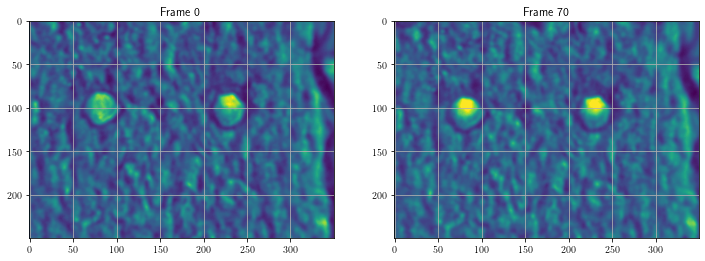

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(12, 12))
frame0 = data.frames[400:650, 350:700, 0]
frame70 = data.frames[400:650, 350:700, 70]

ax[0].imshow(frame0)
ax[0].set_title("Frame 0")

ax[1].imshow(frame70)
ax[1].set_title("Frame 70")

for axi in ax:
    axi.grid()

plt.show()

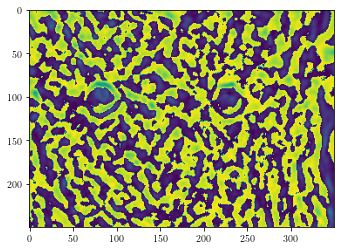

In [6]:
plt.imshow(frame70 - frame0)

## Block matching

![block_matching](block_matching.jpg)

1. Divide images into macro blocks and decide on size of search area
2.

```
  For each block:
    For each location in the search area:
      Compute a similarity (mean square error)
    Find the block inside the search area with the best 
    similarity measure and collect the motion vector
```    

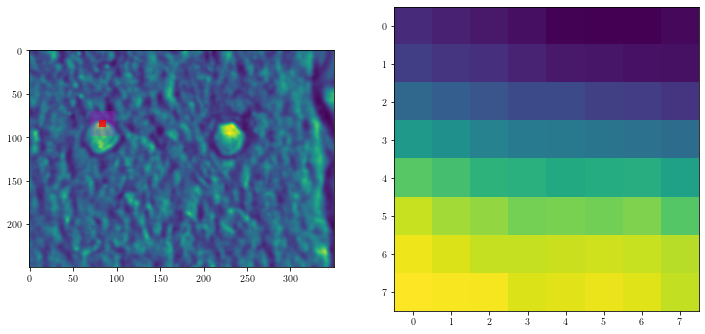

In [7]:
import matplotlib as mpl

x_start = 80
dx = 8
y_start = 80
dy = 8

reference_block = frame0[x_start:x_start + dx, y_start:y_start + dy]
search_x = search_y = 10

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(frame0)
search = mpl.patches.Rectangle(
    (y_start - search_y, x_start-search_x), 
    dy + 2 * search_y, dx + 2 * search_x, facecolor="magenta",
    alpha=0.2,
)
ax[0].add_patch(search)
block = mpl.patches.Rectangle(
    (y_start, x_start), dy, dx, facecolor="red",
    alpha=0.8,
)
ax[0].add_patch(block)

ax[1].imshow(reference_block)

(u, v) = (5, 7)


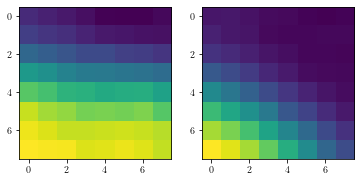

In [8]:
import numpy as np

min_err = np.inf
best_block = None
u = None
v = None
for i, xi in enumerate(range(x_start - search_x, x_start + dx + search_x)):
    for j, yj in enumerate(range(y_start - search_y, y_start + dy + search_y)):
        current_block = frame70[xi:xi+dx, yj:yj+dy]
        err = np.sum(np.abs(reference_block - current_block))
        if err < min_err:
            best_block = current_block
            min_err = err
            u = xi - x_start
            v = yj - y_start
 
print(f"(u, v) = ({u}, {v})")
fig, ax = plt.subplots(1, 2)
ax[0].imshow(reference_block)
ax[1].imshow(best_block)
plt.show()

### Assumptions

- Objects are only translated (not deformed)
- No change in illumination or noise
- Translations are small (within search region)

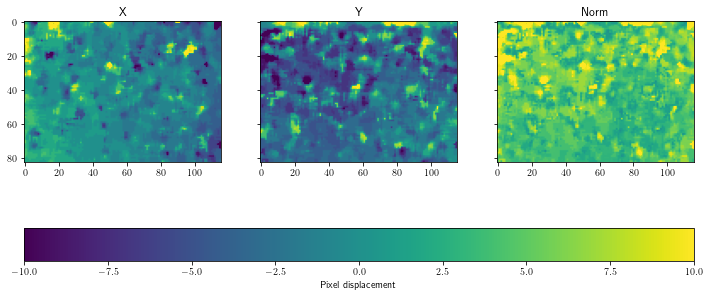

In [59]:
from mps_motion_tracking.block_matching import flow
block_motion = flow(frame0, frame70, block_size=3, max_block_movement=18, filter_kernel_size=5)

# Plot
vmin = -10
vmax = 10
fig, ax = plt.subplots(1, 3, figsize=(12, 8), sharex=True, sharey=True)
ax[0].imshow(block_motion[:, :, 0], vmin=vmin, vmax=vmax)
ax[1].imshow(block_motion[:, :, 1], vmin=vmin, vmax=vmax)
im = ax[2].imshow(np.linalg.norm(block_motion, axis=2), vmin=vmin, vmax=vmax)
for axi, title in zip(ax, ["X", "Y", "Norm"]):
    axi.set_title(title)
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), orientation='horizontal')
cbar.set_label("Pixel displacement")
plt.show()

In [10]:
times = {}
from mps_motion_tracking.block_matching import flow, filter_vectors
times["block matching"] = %timeit -o flow(frame0, frame70, block_size=9, max_block_movement=18, filter_kernel_size=0)

453 ms ± 11.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## The optical flow equation

Let $I(x, y, t)$ denote the image sequence at position $(x, y)$ and time $t$.

Assume that at some later time $t + \Delta t$ the pixel at $(x, y)$ has moved to $(x + \Delta x, y + \Delta y)$.

\begin{align} I(x, y, t) 
&= I(x + \Delta x, y + \Delta y, t + \Delta t) \\
&\approx I(x, y, t) + \frac{\partial I}{\partial x}\Delta x + \frac{\partial I}{\partial y}\Delta y + \frac{\partial I}{\partial t}\Delta t 
\end{align}

\begin{align}  
\frac{\partial I}{\partial x}\Delta x + \frac{\partial I}{\partial y}\Delta y + \frac{\partial I}{\partial t}\Delta t = 0
\end{align}

Divide by $\Delta t$ and let $\Delta t \rightarrow 0$ gives us the optical flow equation

\begin{align}  
\frac{\partial I}{\partial x} V_x + \frac{\partial I}{\partial y} V_y = \nabla I \cdot \vec{V} = - \frac{\partial I}{\partial t}
\end{align}

$V_x$ and $V_y$ are unknown. We need one more equation!

### Image gradient

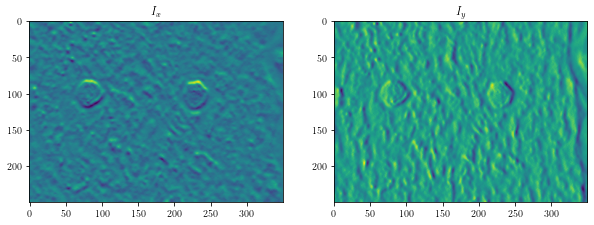

In [11]:
I_x, I_y = np.gradient(frame0)

fig, ax = plt.subplots(1, 2, figsize=(10, 8))
ax[0].imshow(I_x)
ax[0].set_title("$I_x$")
ax[1].imshow(I_y)
ax[1].set_title("$I_y$")
plt.show()

### The Lucas–Kanade method

Assumption: Flow is essentially constant in a local neighbourhood of the pixel under consideration

Consider a pixel $(x, y)$ and select a $5 \times 5$ window around this pixel (i.e 25 pixels).

$$
\begin{pmatrix}
I_x(p_1) & I_y(p_1) \\
\vdots & \vdots \\
I_x(p_{25}) & I_y(p_{25}) \\
\end{pmatrix}
\begin{pmatrix}
V_x \\
V_y \\
\end{pmatrix}
= - \begin{pmatrix}
I_t(p_1) \\
\vdots \\
I_t(p_{25})\\
\end{pmatrix}
\\
$$
or 
$$ A v = b $$



solve least square problem
$$ A^T A v = A^Tb$$

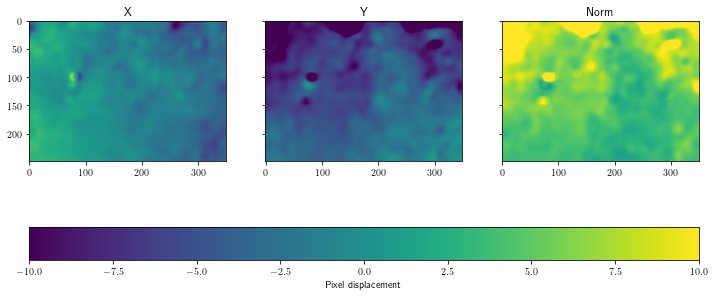

In [61]:
from mps_motion_tracking.lucas_kanade import flow
lk_motion = flow(frame0, frame70, step=2, winSize=(15, 15))


# Plot
vmin = -10
vmax = 10
fig, ax = plt.subplots(1, 3, figsize=(12, 8), sharex=True, sharey=True)
ax[0].imshow(lk_motion[:, :, 0], vmin=vmin, vmax=vmax)
ax[1].imshow(lk_motion[:, :, 1], vmin=vmin, vmax=vmax)
im = ax[2].imshow(np.linalg.norm(lk_motion, axis=2), vmin=vmin, vmax=vmax)
for axi, title in zip(ax, ["X", "Y", "Norm"]):
    axi.set_title(title)
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), orientation='horizontal')
cbar.set_label("Pixel displacement")
plt.show()

### How about performance?

In [13]:
from mps_motion_tracking.lucas_kanade import flow
times["lucas kanade"] = %timeit -o flow(frame0, frame70, step=5, winSize=(15, 15), interpolate=False)

7.75 ms ± 22.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Dense optical flow methods

### Farnebäck's method
Farnebäck, G. (2003, June). Two-frame motion estimation based on polynomial expansion. In Scandinavian conference on Image analysis (pp. 363-370). Springer, Berlin, Heidelberg.


Assumption: image can locally approximated by a quadratic polynomial

Let $\mathbf{x} = (x \; y)$ be a pixel coordinate, then we assumate that the reference image can be represented as

$$I(x, y, t_1) = f_1(\mathbf{x}) = \mathbf{x}^T A_1 \mathbf{x} + b_1^T \mathbf{x} + c_1$$

At a later time $\mathbf{x}$ has moved to $\mathbf{x} - \mathbf{d}$ so we can write the current image as


\begin{align}
I(x, y, t_2) &= f_2(\mathbf{x}) = f_1(\mathbf{x} - \mathbf{d}) \\
&= (\mathbf{x} - \mathbf{d})^T A_1 (\mathbf{x} - \mathbf{d})  + b_1^T (\mathbf{x} - \mathbf{d}) + c_1 \\
&= \mathbf{x}^T A_1 \mathbf{x} + (b_1 - 2A_1 \mathbf{d})^T \mathbf{x} + c_1 +\mathbf{d}^TA\mathbf{d} - b_1^T\mathbf{d}
\end{align}

$$f_2(\mathbf{x}) = \mathbf{x}^T A_2 \mathbf{x} + b_2^T \mathbf{x} + c_2$$

$$ \implies b_2 = b_1 - 2A_1 \mathbf{d} \; \land \; A_1 = A_2 $$
$$ \implies \mathbf{d} = A_1^{-1} \Delta b, \;\; \Delta b = -\frac{1}{2}(b_2 - b_1) $$

In practice we let $A(\mathbf{x}) = \frac{1}{2}(A_1(\mathbf{x}) + A_2(\mathbf{x)})$, perform a polynomial expansion of the two images, and solve the least square problem

$$
\min_{\mathbf{d}} \sum_{\Delta x \in I}w(\Delta x) \| A(\mathbf{x} + \Delta \mathbf{x}) \mathbf{d}(\mathbf{x}) - \Delta b (\mathbf{x}) \|^2
$$

$$
\mathbf{d} = \left( \sum w A^TA \right)^{-1} \sum w A^T \Delta b
$$

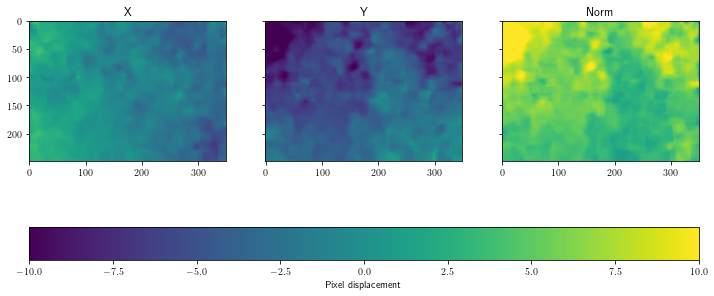

In [14]:
from mps_motion_tracking.farneback import flow
farneback_motion = flow(frame0, frame70)

# Plot
vmin = -10
vmax = 10
fig, ax = plt.subplots(1, 3, figsize=(12, 8), sharex=True, sharey=True)
ax[0].imshow(farneback_motion[:, :, 0], vmin=vmin, vmax=vmax)
ax[1].imshow(farneback_motion[:, :, 1], vmin=vmin, vmax=vmax)
im = ax[2].imshow(np.linalg.norm(farneback_motion, axis=2), vmin=vmin, vmax=vmax)
for axi, title in zip(ax, ["X", "Y", "Norm"]):
    axi.set_title(title)
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), orientation='horizontal')
cbar.set_label("Pixel displacement")
plt.show()

In [15]:
from mps_motion_tracking.farneback import flow
times["farneback"] = %timeit -o flow(frame0, frame70)

20.2 ms ± 808 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Dual TV-L 1
ZACH, Christopher; POCK, Thomas; BISCHOF, Horst. A duality based approach for realtime tv-l 1 optical flow. In: Joint pattern recognition symposium. Springer, Berlin, Heidelberg, 2007. p. 214-223.

Variational approach which minimizes some functional subject to the optical flow constraint.

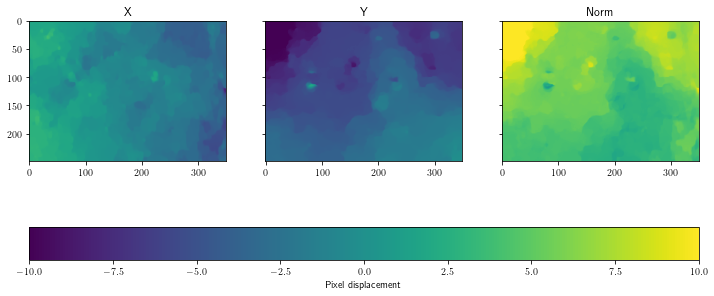

In [16]:
from mps_motion_tracking.dualtvl10 import flow
dualtvl1_motion = flow(frame0, frame70)


# Plot
vmin = -10
vmax = 10
fig, ax = plt.subplots(1, 3, figsize=(12, 8), sharex=True, sharey=True)
ax[0].imshow(dualtvl1_motion[:, :, 0], vmin=vmin, vmax=vmax)
ax[1].imshow(dualtvl1_motion[:, :, 1], vmin=vmin, vmax=vmax)
im = ax[2].imshow(np.linalg.norm(dualtvl1_motion, axis=2), vmin=vmin, vmax=vmax)
for axi, title in zip(ax, ["X", "Y", "Norm"]):
    axi.set_title(title)
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), orientation='horizontal')
cbar.set_label("Pixel displacement")
plt.show()

In [17]:
from mps_motion_tracking.dualtvl10 import flow
times["dualtvl1"] = %timeit -o flow(frame0, frame70)

460 ms ± 2.96 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Comparison

| Type\Performance      || Slow            | Fast         |
|-----------------------||-----------------|--------------|
| **Sparse**            || Block matching  | Lucas Kanade |
| **Dense**             || Dual TV-L 1     | Farnebäck    |

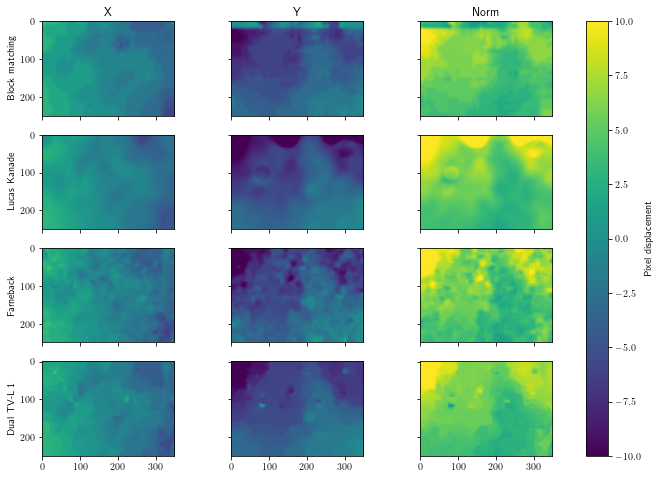

In [18]:
vmin = -10
vmax = 10
import cv2

fig, ax = plt.subplots(4, 3, figsize=(12, 8), sharex=True, sharey=True)
ax[0, 0].imshow(cv2.resize(block_motion[:, :, 0], tuple(reversed(frame0.shape))), vmin=vmin, vmax=vmax)
ax[0, 1].imshow(cv2.resize(block_motion[:, :, 1], tuple(reversed(frame0.shape))), vmin=vmin, vmax=vmax)
ax[0, 2].imshow(cv2.resize(np.linalg.norm(block_motion, axis=2), tuple(reversed(frame0.shape))), vmin=vmin, vmax=vmax)
ax[0, 0].set_ylabel("Block matching")

ax[1, 0].imshow(lk_motion[:, :, 0], vmin=vmin, vmax=vmax)
ax[1, 1].imshow(lk_motion[:, :, 1], vmin=vmin, vmax=vmax)
ax[1, 2].imshow(np.linalg.norm(lk_motion, axis=2), vmin=vmin, vmax=vmax)
ax[1, 0].set_ylabel("Lucas Kanade")

ax[2, 0].imshow(farneback_motion[:, :, 0], vmin=vmin, vmax=vmax)
ax[2, 1].imshow(farneback_motion[:, :, 1], vmin=vmin, vmax=vmax)
ax[2, 2].imshow(np.linalg.norm(farneback_motion, axis=2), vmin=vmin, vmax=vmax)
ax[2, 0].set_ylabel("Farneback")

ax[3, 0].imshow(dualtvl1_motion[:, :, 0], vmin=vmin, vmax=vmax)
ax[3, 1].imshow(dualtvl1_motion[:, :, 1], vmin=vmin, vmax=vmax)
im = ax[3, 2].imshow(np.linalg.norm(dualtvl1_motion, axis=2), vmin=vmin, vmax=vmax)
ax[3, 0].set_ylabel("Dual TV-L 1")

for i, title in enumerate(["X", "Y", "Norm"]):
    ax[0, i].set_title(title)
cbar = fig.colorbar(im, ax=ax.ravel().tolist())
cbar.set_label("Pixel displacement")
plt.show()

## Performance

block matching                          :     0.4528 seconds
lucas kanade                            :   0.007751 seconds
farneback                               :    0.02018 seconds
dualtvl1                                :     0.4599 seconds


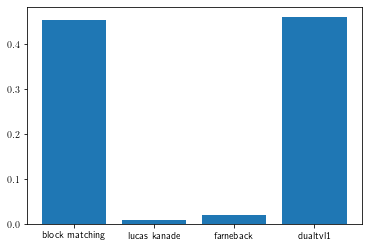

In [19]:
for k, v in times.items():
    print(f"{k:40}: {v.average:10.4} seconds")

plt.bar(times.keys(), list(map(lambda x : x.average, times.values())))
plt.show()

## Optical flow benchmark

Find optical flow in images with known motion

![frame1](../datasets/Dimetrodon/frame10.png)
![frame2](../datasets/Dimetrodon/frame11.png)

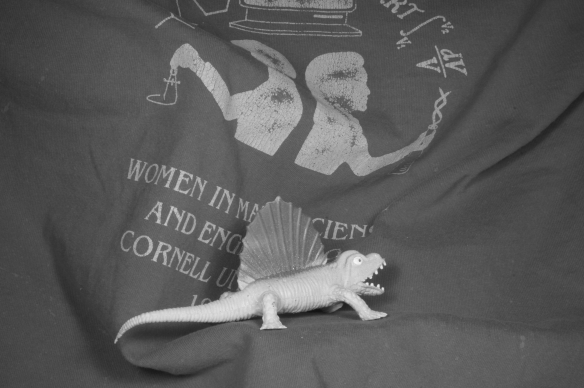

In [20]:
import imageio
images = []
path = "../datasets/Dimetrodon/frame{}.png"
for f in [10, 11]:
    images.append(imageio.imread(path.format(f)))
imageio.mimsave('benchmark_Dimetrodon.gif', images)
from IPython import display
display.Image("benchmark_Dimetrodon.gif")

In [21]:
def benchmark(tf, frames):
    from mps_motion_tracking import (
        block_matching,
        dualtvl10,
        farneback,
        lucas_kanade,
        utils,
    )
    dual_flow = dualtvl10.flow(frames[1], frames[0])
    dual_flow_norm = np.linalg.norm(dual_flow, axis=2)
    dual_flow_norm /= np.nanmax(dual_flow_norm)

    farneback_flow = farneback.flow(
        frames[1],
        frames[0],
    )
    farneback_flow_norm = np.linalg.norm(farneback_flow, axis=2)
    farneback_flow_norm /= farneback_flow_norm.max()

    points = lucas_kanade.get_uniform_reference_points(frames[0], step=4)

    lk_flow = lucas_kanade.flow(frames[1], frames[0], points)
    lk_flow_norm = np.linalg.norm(lk_flow, axis=2)
    lk_flow_norm /= lk_flow_norm.max()

    bm_flow = block_matching.flow(frames[0], frames[1], resize=True)
    bm_flow_norm = np.linalg.norm(bm_flow, axis=2)
    bm_flow_norm /= bm_flow_norm.max()

    vmin = 0
    vmax = 1.0

    fig, ax = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey=True)
    ax[0, 0].imshow(np.linalg.norm(tf, axis=2), vmin=vmin, vmax=vmax)
    ax[0, 0].set_title("True flow")

    ax[1, 0].axis("off")

    ax[0, 1].imshow(dual_flow_norm, vmin=vmin, vmax=vmax)
    ax[0, 1].set_title("dualtvl10")

    ax[0, 2].imshow(farneback_flow_norm, vmin=vmin, vmax=vmax)
    ax[0, 2].set_title("farneback")

    ax[1, 1].imshow(lk_flow_norm, vmin=vmin, vmax=vmax)
    ax[1, 1].set_title("lucas kanade")

    im = ax[1, 2].imshow(bm_flow_norm, vmin=vmin, vmax=vmax)
    ax[1, 2].set_title("block matching")

    cbar = fig.colorbar(im, ax=ax.ravel().tolist(), orientation="horizontal")
    cbar.set_label("Pixel displacement")

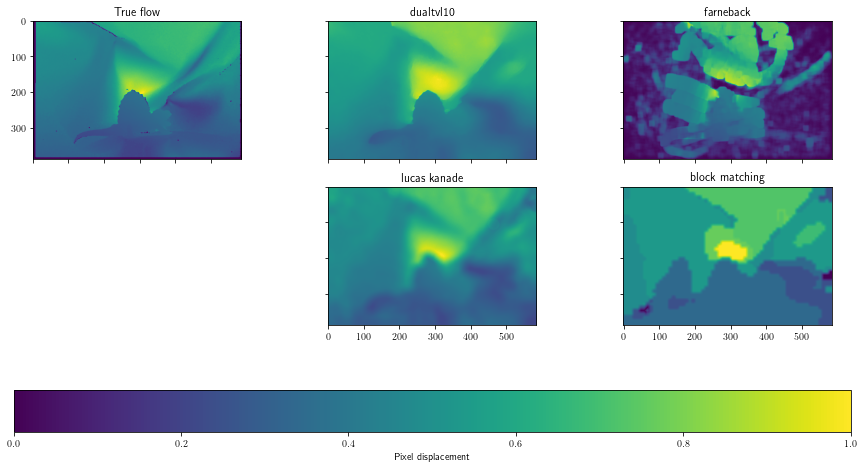

In [22]:
import cv2
import flowiz
folder = Path("../datasets/Dimetrodon")
frames = []
for filename in ["frame10.png", "frame11.png"]:

    image = cv2.imread(folder.joinpath(filename).as_posix())
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    frames.append(gray)

flowfile = folder.joinpath("flow10.flo")
true_flow = flowiz.read_flow(flowfile.as_posix())
tf = np.swapaxes(np.array(flowiz.flowiz._normalize_flow(true_flow)).T, 0, 1)
benchmark(tf, frames)

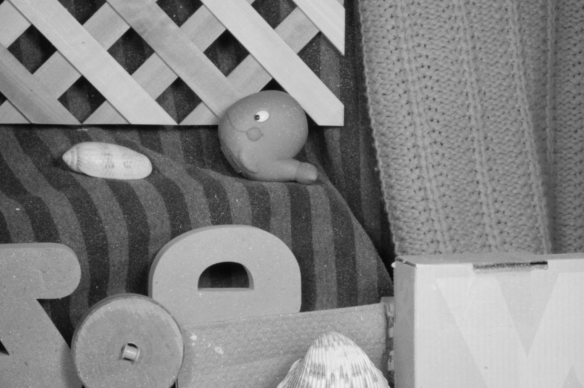

In [23]:
import imageio
images = []
path = "../datasets/RubberWhale/frame{}.png"
for f in [10, 11]:
    images.append(imageio.imread(path.format(f)))
imageio.mimsave('benchmark_RubberWhale.gif', images)
from IPython import display
display.Image("benchmark_RubberWhale.gif")

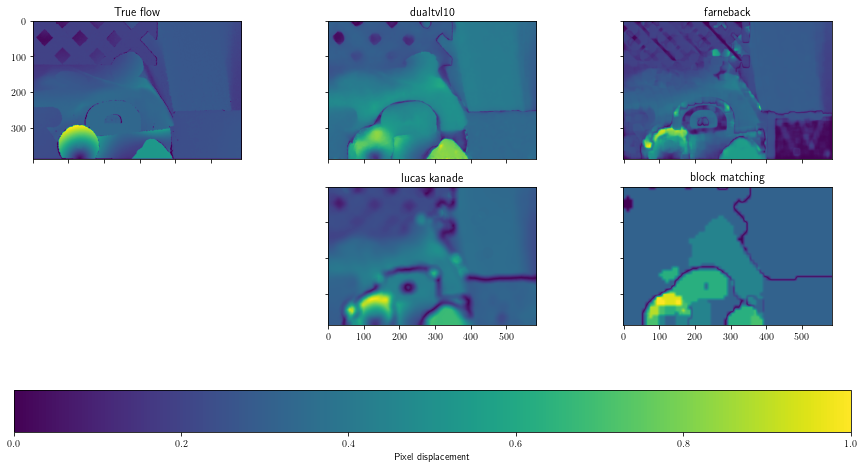

In [24]:
folder = Path("../datasets/RubberWhale")
frames = []
for filename in ["frame10.png", "frame11.png"]:

    image = cv2.imread(folder.joinpath(filename).as_posix())
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    frames.append(gray)

flowfile = folder.joinpath("flow10.flo")
true_flow = flowiz.read_flow(flowfile.as_posix())
tf = np.swapaxes(np.array(flowiz.flowiz._normalize_flow(true_flow)).T, 0, 1)

benchmark(tf, frames)

## Comparing outputs from the different methods

In [25]:
from typing import Dict
import numpy as np
from mps_motion_tracking import OpticalFlow

scale = 0.3

opt_flows: Dict[str, OpticalFlow] = {}
displacements: Dict[str, np.ndarray] = {}

for k in ["farneback", "lucas_kanade", "block_matching", "dualtvl10"]:
    opt_flows[k] = OpticalFlow(data, k)
    displacements[k] = opt_flows[k].get_displacements(scale=scale, unit="um")

Resize frames from (2044, 1174) to (613, 352): 100%|██████████| 267/267 [00:08<00:00, 31.32it/s]
INFO:mps_motion_tracking.farneback:Get displacements using Farneback's algorithm
Resize frames from (2044, 1174) to (613, 352): 100%|██████████| 267/267 [00:08<00:00, 32.64it/s]
INFO:mps_motion_tracking.lucas_kanade:Get displacements using Lucas Kanade
Resize frames from (2044, 1174) to (613, 352): 100%|██████████| 267/267 [00:07<00:00, 35.62it/s]
INFO:mps_motion_tracking.block_matching:Get displacements using block mathching
Resize frames from (2044, 1174) to (613, 352): 100%|██████████| 267/267 [00:07<00:00, 33.54it/s]
INFO:mps_motion_tracking.dualtvl10:Get displacements using Dualt TV-L 1
Compute displacement: 100%|██████████| 267/267 [01:29<00:00,  2.98it/s]


In [26]:
from mps_motion_tracking import Mechancis

mechanics = {}
for k, d in displacements.items():
    mechanics[k] = Mechancis(d)

INFO:mps_motion_tracking.mechanics:Convert displacement to dask array
INFO:mps_motion_tracking.mechanics:Convert displacement to dask array
INFO:mps_motion_tracking.mechanics:Convert displacement to dask array
INFO:mps_motion_tracking.mechanics:Convert displacement to dask array


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1800x1200 -pix_fmt rgba -r 84 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -vcodec libx264 -y disp_farneback.mp4
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1800x1200 -pix_fmt rgba -r 84 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -vcodec libx264 -y disp_lucas_kanade.mp4
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1800x1200 -pix_fmt rgba -r 84 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -vcodec libx264 -y disp_block_matching.mp4
INFO:matplotlib.animation:Animation.save using <cl

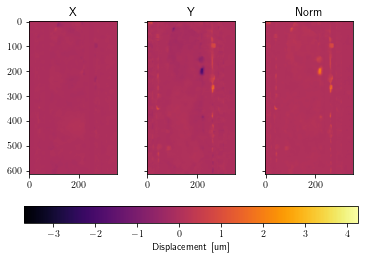

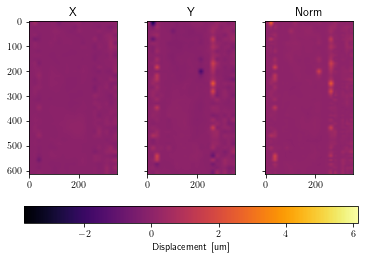

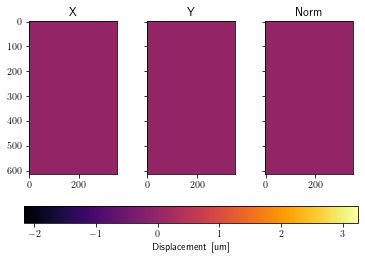

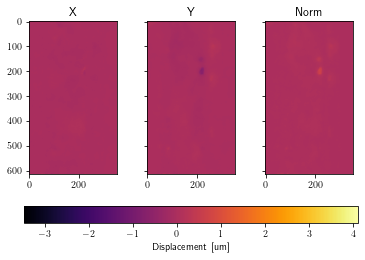

In [27]:
# Create movies
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

for k, m in mechanics.items():
    fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)

    u = m.u.compute()
    u_norm = m.u_norm.compute()

    vmin = u.min()
    vmax = u.max()

    cmap = plt.get_cmap('inferno')
    im1 = ax[0].imshow(u[0, :, :,0], cmap=cmap, vmin=vmin, vmax=vmax)
    im2 = ax[1].imshow(u[0, : , : ,1], cmap=cmap, vmin=vmin, vmax=vmax)
    im3 = ax[2].imshow(u_norm[0, : , :], cmap=cmap, vmin=vmin, vmax=vmax)
    ax[0].set_title("X")
    ax[1].set_title("Y")
    ax[2].set_title("Norm")

    cbar = fig.colorbar(im1, ax=ax.ravel().tolist(), orientation='horizontal')
    cbar.set_label("Displacement [um]")

    def animate_func(i):
        im1.set_array(u[i, :, :,0])
        im2.set_array(u[i, :, :,1])
        im3.set_array(u_norm[i, :, :])
        return [im1, im2, im3]

    anim = animation.FuncAnimation(fig, animate_func, frames = u.shape[0])

    #writer = animation.writers["ffmpeg"](fps=data.framerate)
    anim.save(f"disp_{k}.mp4", fps=data.framerate, dpi=300, extra_args=['-vcodec', 'libx264'])

## Spatial displacement

In [64]:
from IPython.display import Video
#Video(f"disp_block_matching.mp4", width=800, html_attributes="controls loop")
#Video(f"disp_lucas_kanade.mp4", width=800, html_attributes="controls loop")
#Video(f"disp_farneback.mp4", width=800, html_attributes="controls loop")
Video(f"disp_dualtvl10.mp4", width=800, html_attributes="controls loop")

## Maximal spatial displacement

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 3600x3600 -pix_fmt rgba -r 84 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -vcodec libx264 -y disp_norm.mp4


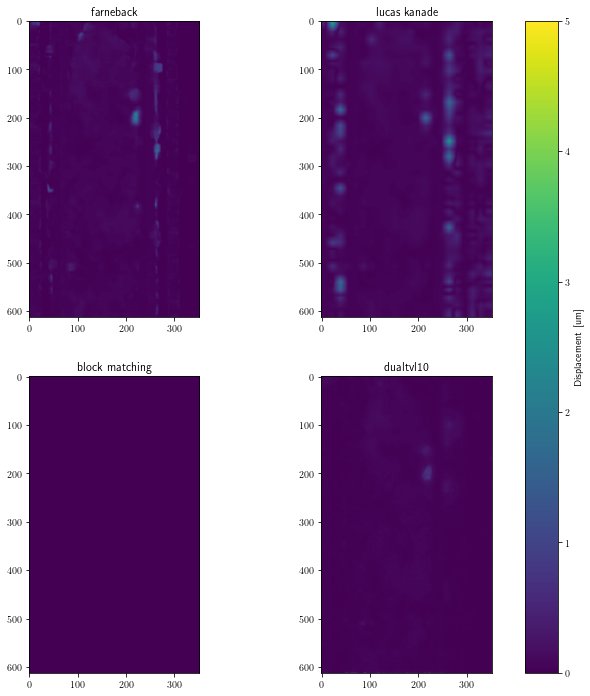

In [29]:
# Create movies
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


fig, axs = plt.subplots(2, 2, figsize=(12, 12))
vmin = 0
vmax = 5
ims = {}
us = {}
cmap = plt.get_cmap('viridis')
for k, m in mechanics.items():
    us[k] =  m.u_norm.compute()
    
for (k, u), ax in zip(us.items(), axs.flatten()):
    ims[k] = ax.imshow(u[0, :, :], cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(" ".join(k.split("_")))
    
cbar = fig.colorbar(ims[k], ax=axs.ravel().tolist())
cbar.set_label("Displacement [um]")

def animate_func(i):
    for u, im in zip(us.values(), ims.values()):
        im.set_array(u[i, :, :])
    return list(ims.values())

anim = animation.FuncAnimation(fig, animate_func, frames = u.shape[0])

#writer = animation.writers["ffmpeg"](fps=data.framerate)
anim.save(f"disp_norm.mp4", fps=data.framerate, dpi=300, extra_args=['-vcodec', 'libx264'])

In [65]:
from IPython.display import Video
Video(f"disp_norm.mp4", width=800, html_attributes="controls loop")

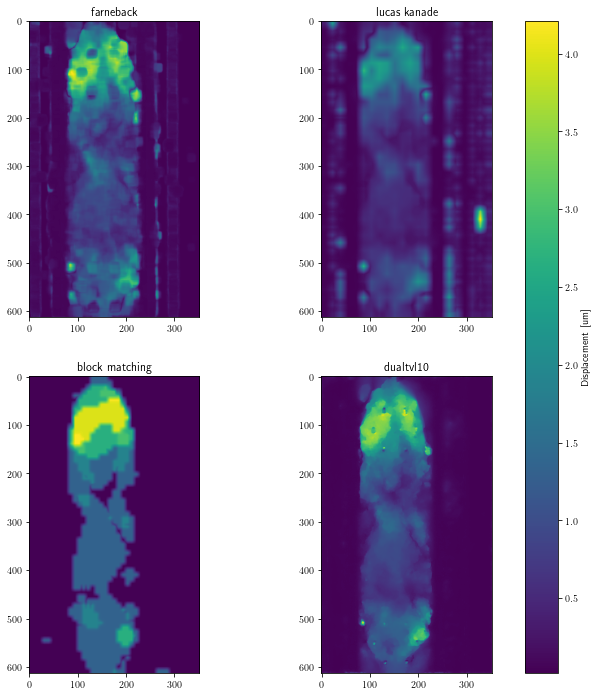

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
vmin = 0
vmax = 5
for (k, m), ax in zip(mechanics.items(), axs.flatten()):
    im = ax.imshow(m.u_norm.max(0).compute())
    ax.set_title(" ".join(k.split("_")))
cbar = fig.colorbar(im, ax=axs.ravel().tolist())
cbar.set_label("Displacement [um]")
plt.show()

## Average displacement as a function of time

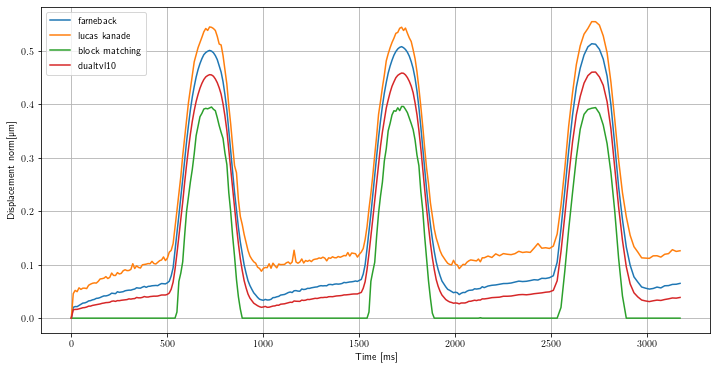

In [32]:
fig, ax = plt.subplots(figsize=(12, 6))
labels = []
lines = []
for k, m in mechanics.items():
    ax.plot(data.time_stamps, m.u_mean_norm.compute(), label=" ".join(k.split("_")))
    
ax.grid()
ax.legend()
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Displacement norm[\u00B5m]")
plt.show()

### How about local variations?

In [33]:
m = mechanics["farneback"]
from mps.analysis import local_averages
frames = m.u_norm.compute()
la = local_averages(np.rollaxis(np.swapaxes(frames, 0, -1), 1), data.time_stamps, background_correction=False, N=10)

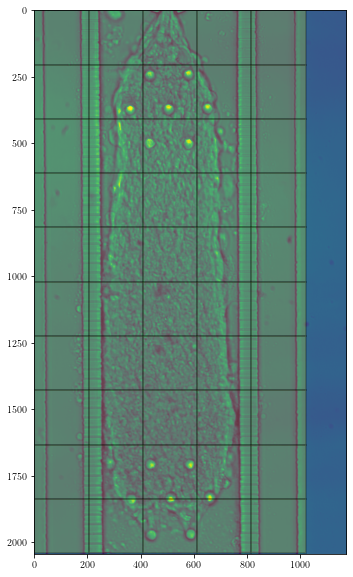

In [34]:
import matplotlib as mpl
from mps import utils

grid = utils.get_grid_settings(N=10, frames=data.frames)

fig, ax = plt.subplots(figsize=(6, 10))
ax.imshow(data.frames.T[0].T)

for i in range(grid.nx):
    for j in range(grid.ny):

        p = mpl.patches.Rectangle(
            (j * grid.dy, i * grid.dx),
            grid.dy,
            grid.dx,
            linewidth=2,
            edgecolor="k",
            facecolor="yellow",
            alpha=0.2,
        )
        ax.add_patch(p)
plt.show()

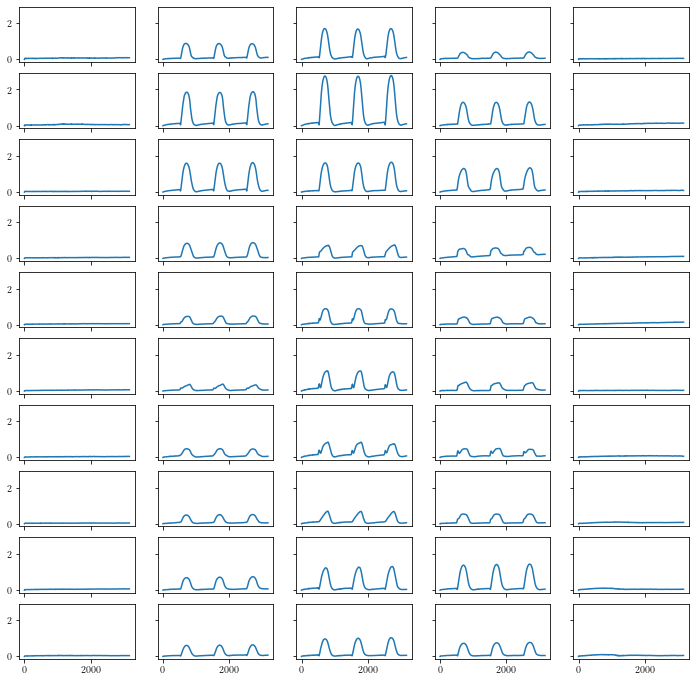

In [35]:
fig, ax = plt.subplots(la.shape[0], la.shape[1], sharex=True, sharey=True, figsize=(12, 12))
for i in range(la.shape[0]):
    for j in range(la.shape[1]):
        ax[i, j].plot(data.time_stamps, la[i, j, :])
plt.show()

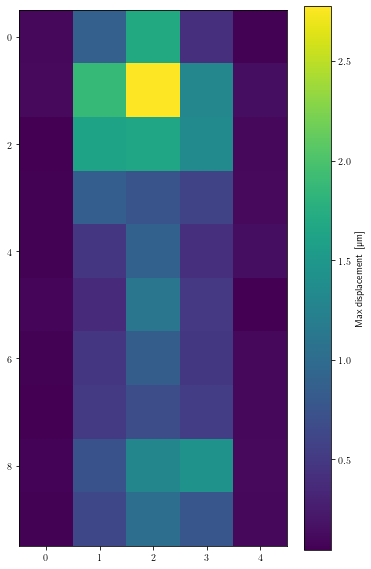

In [36]:
max_local_displacement = np.max(la, axis=2)
fig, ax = plt.subplots(figsize=(6, 10))
im = ax.imshow(max_local_displacement)
cbar = fig.colorbar(im)
cbar.set_label("Max displacement [\u00B5m]")
plt.show()

Max index =  (1, 2)


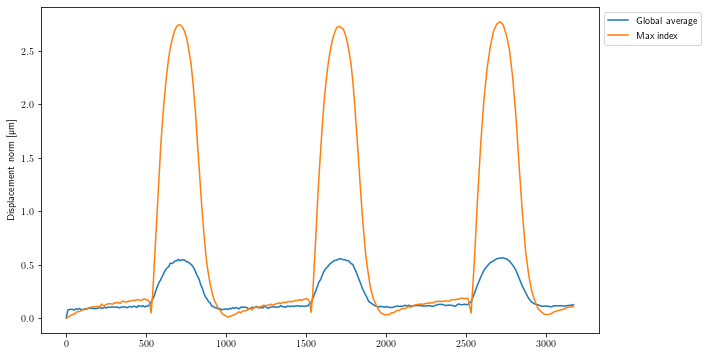

In [55]:
max_idx = np.unravel_index(np.argmax(max_local_displacement),max_local_displacement.shape)
print("Max index = ", max_idx)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(data.time_stamps, m.u_mean_norm, label="Global average")
ax.plot(data.time_stamps, la[max_idx[0], max_idx[1], :], label="Max index")
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax.set_ylabel("Displacement norm [\u00B5m]")
plt.show()

### How about resizing?

INFO:mps_motion_tracking.farneback:Get displacements using Farneback's algorithm
Compute displacement: 100%|██████████| 267/267 [01:04<00:00,  4.17it/s]
INFO:mps_motion_tracking.mechanics:Convert displacement to dask array
Resize frames from (2044, 1174) to (1430, 821): 100%|██████████| 267/267 [00:10<00:00, 24.34it/s]
INFO:mps_motion_tracking.farneback:Get displacements using Farneback's algorithm
Compute displacement: 100%|██████████| 267/267 [00:52<00:00,  5.11it/s]
INFO:mps_motion_tracking.mechanics:Convert displacement to dask array
Resize frames from (2044, 1174) to (1022, 587): 100%|██████████| 267/267 [00:10<00:00, 25.99it/s]
INFO:mps_motion_tracking.farneback:Get displacements using Farneback's algorithm
Compute displacement: 100%|██████████| 267/267 [00:22<00:00, 11.74it/s]
INFO:mps_motion_tracking.mechanics:Convert displacement to dask array
Resize frames from (2044, 1174) to (613, 352): 100%|██████████| 267/267 [00:08<00:00, 29.81it/s]
INFO:mps_motion_tracking.farneback:Get

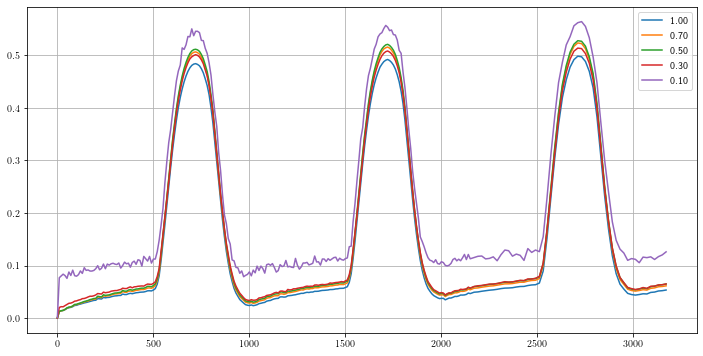

In [38]:
import matplotlib.pyplot as plt
from mps_motion_tracking import OpticalFlow, Mechancis

opt_flow = OpticalFlow(data, "farneback")

fig, ax = plt.subplots(figsize=(12, 6))

for scale in [1, 0.7, 0.5, 0.3, 0.1]: 
    d = opt_flow.get_displacements(scale=scale, unit="um")
    m = Mechancis(d)
    ax.plot(data.time_stamps, m.u_mean_norm.compute(), label=f"{scale:.2f}")
    
ax.grid()
ax.legend()
plt.show()

## Next steps
- Test method on real data - do we observe expected changes when exposed to drugs?
- Implement GUI in Web application


### Other potential directions
- Try more modern methods for motion tracking - based on deep learning
- Train neural network (NN) to learn the motion (from pixels)
- Use Pysics Informed- or Physics Guided NN

![identphy](figures/identiphy.png)

![team](figures/team.png)

<table>
    <tr>
        <td>
        <img src="https://biomaterials.berkeley.edu/wp-content/uploads/2018/08/healy-e1535756168121-500x500.jpg" />
            Kevin Healy
        </td>
        <td>
        <img src="https://biomaterials.berkeley.edu/wp-content/uploads/2018/08/verena-e1534797943921-500x500.png" />
            Verena Charwat
        </td>
        <td>
        <img src="https://biomaterials.berkeley.edu/wp-content/uploads/2018/08/Berenice2-1-e1533922001664.jpg" />
            Berenice Charrez
        </td>
    </tr>
</table>